In [1]:
import pandas as pd

In [2]:
YEAR = 2023

In [3]:
default_cols = ['Ff Catpro2txt', "Invariant", "Anmutation"]
biscom_owners_cols = ["Proprietaire", "Gestre Ppre", "Adresse1", "Adresse2", "Adresse3", "Adresse4", ]

In [4]:
ff_owners_columns = [
 'Ff Jdatnss 1',
 'Ff Ddenom 1',
 'Ff Dlign3 1',
 'Ff Dlign4 1',
 'Ff Dlign5 1',
 'Ff Dlign6 1',
 'Ff Jdatnss 2',
 'Ff Ddenom 2',
 'Ff Dlign3 2',
 'Ff Dlign4 2',
 'Ff Dlign5 2',
 'Ff Dlign6 2',
 'Ff Jdatnss 3',
 'Ff Ddenom 3',
 'Ff Dlign3 3',
 'Ff Dlign4 3',
 'Ff Dlign5 3',
 'Ff Dlign6 3',
 'Ff Jdatnss 4',
 'Ff Ddenom 4',
 'Ff Dlign3 4',
 'Ff Dlign4 4',
 'Ff Dlign5 4',
 'Ff Dlign6 4',
 'Ff Jdatnss 5',
 'Ff Ddenom 5',
 'Ff Dlign3 5',
 'Ff Dlign4 5',
 'Ff Dlign5 5',
 'Ff Dlign6 5',
 'Ff Jdatnss 6',
 'Ff Ddenom 6',
 'Ff Dlign3 6',
 'Ff Dlign4 6',
 'Ff Dlign5 6',
 'Ff Dlign6 6',
]

In [5]:
from collections import defaultdict


ff_owners_columns_separated = defaultdict(list)
for col in ff_owners_columns:
    index = col.split(" ")[-1]
    ff_owners_columns_separated[index].append(col)

In [53]:
import numpy as np


def clean_df_ff(df, index, cols):
    address_cols = df[cols].filter(regex="lign").columns
    name_col = df[cols].filter(regex="denom").columns[0]
    date_col = df[cols].filter(regex="datnss").columns[0]
    for i in range(3, 7):
        df[f"ff_owner_{index}_address_{i-2}"] = df[f"Ff Dlign{i} {index}"]
    df[f"ff_owner_{index}_partial_address"] = np.add.reduce(df[address_cols[0:2]].fillna("") + " ", axis=1)
    df[f"ff_owner_{index}_address"] = np.add.reduce(df[address_cols].fillna("") + " ", axis=1)
    df[f"ff_owner_{index}_city"] = df[address_cols[-1]]
    df[f"ff_owner_{index}_name"] = df[name_col].astype(str).str.replace("-", " ")
    df[f"ff_owner_{index}_birth_date"] = pd.to_datetime(df[date_col], errors="ignore", dayfirst=True)
    # df = df.drop(list(address_cols) + [name_col, date_col], axis=1)
    return df
    

In [54]:
from tqdm.auto import tqdm

In [25]:
df_owners = pd.read_csv("data/zlovac_2023.csv",
                        usecols=default_cols + ff_owners_columns + biscom_owners_cols, nrows=None)

/var/folders/_v/10w6h3595jb25htv66pv5fq80000gn/T/ipykernel_79206/764789306.py:1: DtypeWarning: Columns (73,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df_owners = pd.read_csv("data/zlovac_2023.csv",


In [26]:
for index, cols in tqdm(ff_owners_columns_separated.items()):
    df_owners = clean_df_ff(df_owners, index=index, cols=cols)

df_owners = df_owners.drop(ff_owners_columns, axis=1, errors="ignore")

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
def _clean_m_mme_from_name(x: str):
    if isinstance(x, str):
        x = x.replace("-", " ")
        if x.startswith("M "): 
            return x[2:]
        elif x.startswith("MME "):
            return x[4:]
    return x

In [28]:
def clean_df_biscom(df):
    address_cols = ["Adresse1", "Adresse2","Adresse3","Adresse4"]
    
    for i in range(1, 5):
        df[f"biscom_owner_address_{i}"] = df[f"Adresse{i}"]
    df["biscom_owner_partial_address"] = np.add.reduce(df[address_cols[0:2]].fillna("") + " ", axis=1)
    df["biscom_owner_city"] = df["Adresse4"]

    df["biscom_owner_address"] = np.add.reduce(df[address_cols].fillna("") + " ", axis=1)
    df["biscom_owner_name"] = df["Proprietaire"].fillna(df["Gestre Ppre"])
    df["biscom_owner_name"] = df["biscom_owner_name"].apply(_clean_m_mme_from_name)
    df = df.drop(list(address_cols) + ["Proprietaire", "Gestre Ppre"], axis=1)
    return df

In [29]:
df_owners = clean_df_biscom(df_owners)

# Match 

In [30]:
from thefuzz import fuzz
FUZZY_RATIO = 80

In [31]:
def match(a, b):
    return fuzz.token_set_ratio(a, b) > FUZZY_RATIO

In [32]:
from tqdm.auto import tqdm 

In [33]:
for index in tqdm(range(1,7)):
    df_owners[f"match_partial_address_{index}"] = df_owners.apply(
        lambda x: match(x[f'ff_owner_{index}_partial_address'], x['biscom_owner_partial_address']), 
        axis=1
    )
    df_owners[f"match_city_{index}"] = df_owners.apply(
        lambda x: match(x[f'ff_owner_{index}_city'], x['biscom_owner_city']), 
        axis=1
    )
    df_owners[f"match_fullname_{index}"] = df_owners.apply(
        lambda x: match(x[f'ff_owner_{index}_name'], x['biscom_owner_name']), 
        axis=1
    )

  0%|          | 0/6 [00:00<?, ?it/s]

## Match first names

In [34]:
df_prenom = pd.read_csv("./data/prenom.csv")
list_first_names = df_prenom[df_prenom["sum"] > 100]["prenom"].tolist()

In [35]:
#!pip install flashtext

In [36]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
keyword_processor.add_keywords_from_list(list_first_names)

In [37]:
df_owners["biscom_owner_first_names"] = df_owners["biscom_owner_name"].fillna("").apply(keyword_processor.extract_keywords)
for index in tqdm(range(1,7)):
    df_owners[f"ff_owner_{index}_first_names"] = df_owners[f"ff_owner_{index}_name"].fillna("").apply(keyword_processor.extract_keywords)
    df_owners[f"match_same_first_name_{index}"] = df_owners.apply(
        lambda x: len(set(x["biscom_owner_first_names"]).intersection(set(x[f"ff_owner_{index}_first_names"]))) >= 1, axis=1)


  0%|          | 0/6 [00:00<?, ?it/s]

## Explore 

In [42]:
df_match = df_owners.filter(regex="match_")

In [48]:
df_owners.filter(regex="_1").columns

Index(['ff_owner_1_address_1', 'ff_owner_1_address_2', 'ff_owner_1_address_3',
       'ff_owner_1_address_4', 'ff_owner_1_partial_address',
       'ff_owner_1_address', 'ff_owner_1_city', 'ff_owner_1_name',
       'ff_owner_1_birth_date', 'ff_owner_2_address_1', 'ff_owner_3_address_1',
       'ff_owner_4_address_1', 'ff_owner_5_address_1', 'ff_owner_6_address_1',
       'biscom_owner_address_1', 'match_partial_address_1', 'match_city_1',
       'match_fullname_1', 'ff_owner_1_first_names',
       'match_same_first_name_1'],
      dtype='object')

In [43]:
df_match.head()

,match_partial_address_1,match_city_1,match_fullname_1,match_partial_address_2,match_city_2,match_fullname_2,match_partial_address_3,match_city_3,match_fullname_3,match_partial_address_4,...,match_fullname_5,match_partial_address_6,match_city_6,match_fullname_6,match_same_first_name_1,match_same_first_name_2,match_same_first_name_3,match_same_first_name_4,match_same_first_name_5,match_same_first_name_6
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


## Rules
- Prénom + Nom + Adresse <> Prénom + Nom + Adresse = 10
- Prénom + Nom + commune <> Prénom + Nom + commune = 9
- Prénom + Nom <> Prénom + Nom = 8
- Prénom + Adresse entière <> Prénom + Adresse entière = 7
- Prénom + Commune <> Prénom + Commune = 6
- Prénom <> Prénom = 5
- Si mutation dans les 2 dernières années, alors on prend 1767 = 2
- Si non, on prend 1767 = 1

In [51]:
def define_score(x, index):
    if x[f"match_fullname_{index}"] == True:
        if x[f"match_partial_address_{index}"] == True:
            return 10
        if x[f"match_city_{index}"] == True:
            return 9
        return 8
    if x["match_same_first_name_3"] == True:
        if x[f"match_partial_address_{index}"] == True:
            return 7
        if x[f"match_city_{index}"] == True:
            return 6
        return 5
    

In [52]:
for index in tqdm(range(1, 7)):
    df_owners[f"final_owner_{index}_score"]   = df_owners.apply(lambda x: define_score(x, index=index), axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [64]:
import matplotlib.pyplot as plt

<AxesSubplot: >

In [75]:
 df_owners[f"final_owner_1_score"].value_counts()

final_owner_1_score
10.0    700684
9.0      56822
8.0      39613
7.0       3351
5.0       1494
6.0        469
Name: count, dtype: int64

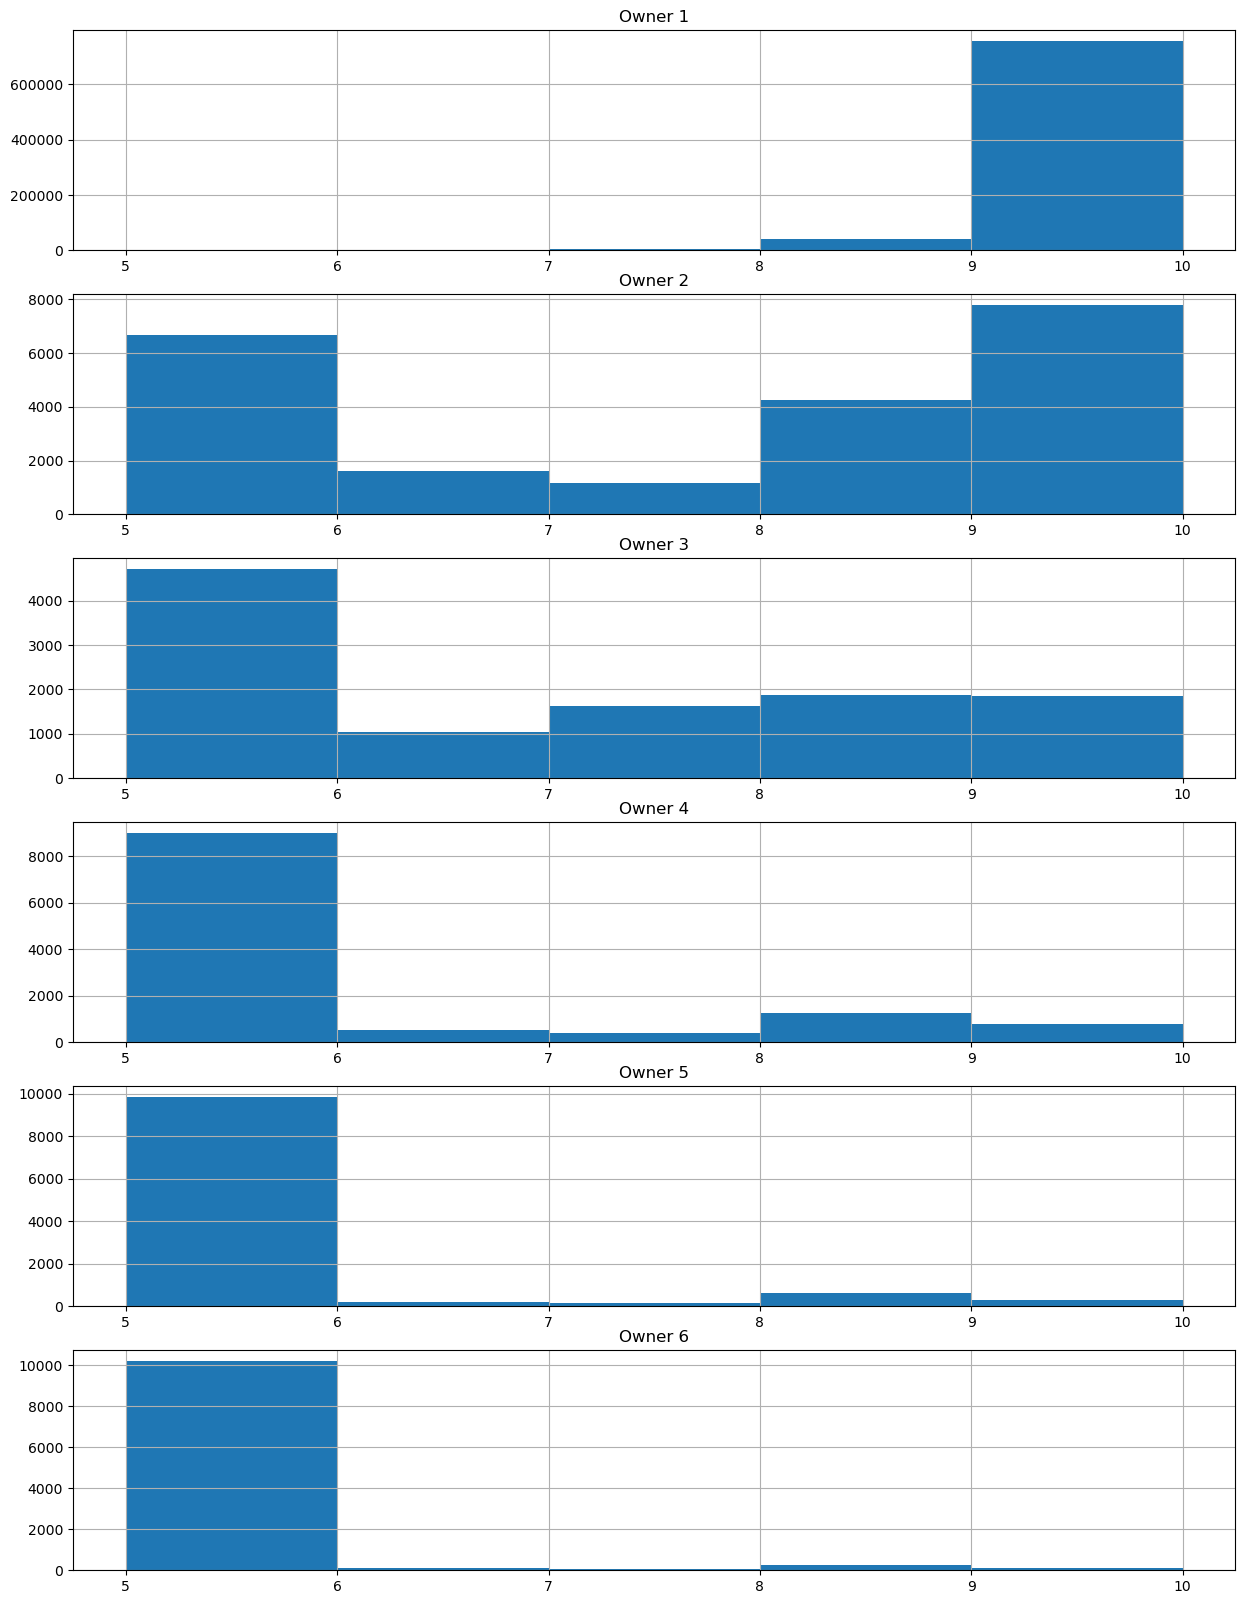

In [74]:
fig, axes = plt.subplots(6, 1, figsize=(15,20))

for i, ax in zip(range(1, 7), axes):
    df_owners[f"final_owner_{i}_score"].hist(bins=5, ax=ax)
    ax.set_title(f"Owner {i}")

In [76]:
df_owners.head()

,Invariant,Anmutation,Ff Catpro2txt,ff_owner_1_address_1,ff_owner_1_address_2,ff_owner_1_address_3,ff_owner_1_address_4,ff_owner_1_partial_address,ff_owner_1_address,ff_owner_1_city,...,ff_owner_5_first_names,match_same_first_name_5,ff_owner_6_first_names,match_same_first_name_6,final_owner_1_score,final_owner_2_score,final_owner_3_score,final_owner_4_score,final_owner_5_score,final_owner_6_score
0,I0240007617G,24/01/2022,SOCIETE CIVILE A VOCATION IMMOBILIERE,NaN,0110 ALL HENRI MARTIN,NaN,01400 NEUVILLE-LES-DAMES,0110 ALL HENRI MARTIN,0110 ALL HENRI MARTIN 01400 NEUVILLE-LES-DAMES,01400 NEUVILLE-LES-DAMES,...,[],False,[],False,NaN,NaN,NaN,NaN,NaN,NaN
1,I0240007667Z,07/05/2021,PERSONNE PHYSIQUE,NaN,0383BCHE DES CHAMPAGNES,NaN,38890 SALAGNON,0383BCHE DES CHAMPAGNES,0383BCHE DES CHAMPAGNES 38890 SALAGNON,38890 SALAGNON,...,[],False,[],False,10.0,NaN,NaN,NaN,NaN,NaN
2,I0240007670Y,12/12/2011,PERSONNE PHYSIQUE,NaN,0292 ALL DES HIRONDELLES,NaN,01440 VIRIAT,0292 ALL DES HIRONDELLES,0292 ALL DES HIRONDELLES 01440 VIRIAT,01440 VIRIAT,...,[],False,[],False,10.0,NaN,NaN,NaN,NaN,NaN
3,I0240007679J,07/07/2009,PERSONNE PHYSIQUE,NaN,0356 GR GRANDE RUE,NaN,01370 BENY,0356 GR GRANDE RUE,0356 GR GRANDE RUE 01370 BENY,01370 BENY,...,[],False,[],False,NaN,NaN,NaN,NaN,NaN,NaN
4,I0240007680S,02/10/2015,PERSONNE PHYSIQUE,NaN,0165 RUE DU LAVOIR,NaN,01600 REYRIEUX,0165 RUE DU LAVOIR,0165 RUE DU LAVOIR 01600 REYRIEUX,01600 REYRIEUX,...,[],False,[],False,10.0,NaN,NaN,NaN,NaN,NaN


In [105]:
df_owners.filter(regex="name")

,ff_owner_1_name,ff_owner_2_name,ff_owner_3_name,ff_owner_4_name,ff_owner_5_name,ff_owner_6_name,biscom_owner_name,match_fullname_1,match_fullname_2,match_fullname_3,...,ff_owner_2_first_names,match_same_first_name_2,ff_owner_3_first_names,match_same_first_name_3,ff_owner_4_first_names,match_same_first_name_4,ff_owner_5_first_names,match_same_first_name_5,ff_owner_6_first_names,match_same_first_name_6
0,SCI L'AMITIE,nan,nan,nan,nan,nan,KOZAN RIDVAN,False,False,False,...,[],False,[],False,[],False,[],False,[],False
1,BREVET SYLVAIN GEORGES,BREVET MARIE NOELLE,nan,nan,nan,nan,BREVET SYLVAIN,True,False,False,...,"[MARIE, NOELLE]",False,[],False,[],False,[],False,[],False
2,BOZONNET ROLAND LOUIS,nan,nan,nan,nan,nan,BOZONNET ROLAND,True,False,False,...,[],False,[],False,[],False,[],False,[],False
3,MERLE ELODIE,MERLE VIRGINIE,nan,nan,nan,nan,LELARDOUX ELODIE,False,False,False,...,[VIRGINIE],False,[],False,[],False,[],False,[],False
4,CHANEL GILLES,CHANEL JEAN PIERRE HENRI GILBERT,nan,nan,nan,nan,CHANEL GILLES,True,False,False,...,"[JEAN, PIERRE, HENRI, GILBERT]",False,[],False,[],False,[],False,[],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,BADUEL STANISLAS GUILLAUME,HERMANGE NATHALIE MARTINE JOELLE,nan,nan,nan,nan,BADUEL STANISLAS,True,False,False,...,"[NATHALIE, MARTINE, JOELLE]",False,[],False,[],False,[],False,[],False
1048571,JACOB GUENAELLE GENEVIEVE ODILE,JACOB ANNE YVETTE CLAIRE HELENE,nan,nan,nan,nan,MENGUY THOMAS,False,False,False,...,"[JACOB, ANNE, YVETTE, CLAIRE, HELENE]",False,[],False,[],False,[],False,[],False
1048572,LIEURY XAVIER,nan,nan,nan,nan,nan,LIEURY XAVIER,True,False,False,...,[],False,[],False,[],False,[],False,[],False
1048573,CHARLET JEAN CLAUDE,nan,nan,nan,nan,nan,CHARLET JEAN CLAUDE,True,False,False,...,[],False,[],False,[],False,[],False,[],False


In [110]:
birth_cols = list(df_owners.filter(regex="ff_owner_[0-9]_birth").columns)
address_cols = list(df_owners.filter(regex="ff_owner_[0-9]_address_[0-9]").columns)
full_name_cols = list(df_owners.filter(regex="ff_owner_[0-9]_name").columns)

In [111]:
birth_cols

['ff_owner_1_birth_date',
 'ff_owner_2_birth_date',
 'ff_owner_3_birth_date',
 'ff_owner_4_birth_date',
 'ff_owner_5_birth_date',
 'ff_owner_6_birth_date']

In [112]:
df_owners[birth_cols + address_cols + full_name_cols].to_csv("data/matched.csv", index=False)

In [ ]:
[
{
"owner_fullname":str,
"owner_firstname":str,
"owner_lastname":str,
"owner_address1": str,
"owner_address2": str,
"owner_address3": str,
"owner_address4": str,
"owner_full_address": str,
"owner_birth_date": date<optional>, 
"source": 1767 | ff,
"motif": str, 
"score": int <1-10>, 
"idpersonne":str <optional>, "idprocpte": [str] <optional>, "idprodroit": [str]<optional>
}
]

In [91]:
def build(x):
    data = []
    for i in range(1, 7):
        if x[f"ff_owner_{i}_name"] != 'nan':
            data.append({
                "owner_fullname":x[f"ff_owner_{i}_name"],
                "owner_firstname":x[f"ff_owner_{i}_first_names"],
                "owner_lastname": None,
                "owner_address1": x[f"ff_owner_{i}_address_1"],
                "owner_address2": x[f"ff_owner_{i}_address_2"],
                "owner_address3": x[f"ff_owner_{i}_address_3"],
                "owner_address4": x[f"ff_owner_{i}_address_4"],
                "owner_address": x[f"ff_owner_{i}_address"],
                "owner_birth_date": pd.to_datetime(x[f"ff_owner_{i}_birth_date"], dayfirst=True), 
                "source": "ff",
                "motif": str, 
                "score": x[f"final_owner_{i}_score"], 
            })
    return data
        
        
        

In [92]:
df_owners.head().apply(build, axis=1).iloc[0]

[{'owner_fullname': "SCI L'AMITIE",
  'owner_firstname': [],
  'owner_lastname': None,
  'owner_address1': nan,
  'owner_address2': '0110 ALL HENRI MARTIN',
  'owner_address3': nan,
  'owner_address4': '01400 NEUVILLE-LES-DAMES',
  'owner_address': ' 0110 ALL HENRI MARTIN  01400 NEUVILLE-LES-DAMES ',
  'owner_birth_date': NaT,
  'source': 'ff',
  'motif': str,
  'score': nan}]